# Fantasy Football - Player Draft Value Analysis

## Conceptual Overview
This script performs feature engineering to create metrics at both **weekly** and **player** levels. 

- The **weekly-level dataset** will be used as input for the **Neural Network** in `NN_Model.ipynb` to predict weekly player performance.
- The **player-level dataset** will be used as input for the **Gaussian Mixture Model (GMM)** in `GMM_draft_tiers.ipynb` to optimize draft strategy.
- This structured approach enhances **fantasy football draft decision-making** by combining **machine learning insights** with **historical performance trends**.

---

## Process Overview
### Processing Weekly Fantasy Football Data
- Aggregates **player data at the season level** for tier assignment.
- Evaluates **skill position players** across the entire **2024 season**.
- **Excludes** Kickers & Defenses for more realistic **draft analysis and tier assignments**.

### Feature Engineering
- Creates **meaningful player metrics** to evaluate:
  - **Performance consistency**
  - **Explosiveness** (Boom potential)
  - **Efficiency** (Actual vs. projected performance)
- Enhances **player rankings** before assigning **draft tiers**.

### Rolling Averages for Trend Analysis
- **Short-term performance trends** captured by:
  - `prev_week_points` = **Previous week's points**.
  - `last_3_avg` = **Rolling 3-week average**.

### Boom/Bust Weeks for Volatility
- Identifies **high-risk, high-reward players**:
  - **Boom weeks** = Games where a player **exceeds 20 fantasy points**.
  - **Bust weeks** = Games where a player **scores fewer than 7 points**.

### High Ceiling & Low Floor Metrics
- Uses **percentile-based metrics**:
  - **High Ceiling (Top 25%)** = **Consistent elite performances**.
  - **Low Floor (Bottom 25%)** = **Frequent poor performances**.

### Player-Level Aggregation
- Computes:
  - **Total & average fantasy points**
  - **Weekly participation**
  - **Variability metrics**

### Availability & Consistency Scores
- **Availability Score** = Measures **games played relative to the 17-week season**.
- **Consistency Score** = Evaluates reliability using:
  - `PPG / Standard Deviation`
  - Lower variance = **more reliable player**.

### Efficiency Ratio
- Measures **performance vs. preseason projections**:
  - Players with **high efficiency** **outperform expectations**.

### Key Player Profiles for Draft Strategy
- **High Boom Weeks + High Efficiency Ratio** = Players who exceed expectations & have explosive games.
- **High Weekly Consistency Score** = Safe fantasy picks who **score reliably each week**.
- **Low Bust Weeks + High Availability** = **Healthy, dependable players** who are **less likely to disappoint**.

---

In [4]:
#############################################
### Import Libraries
#############################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

## set pandas display options
pd.set_option('display.max_rows', None)          ## remove row display limit
pd.set_option('display.max_columns', None)       ## remove column display limit
pd.set_option('display.max_colwidth', None)      ## ensure full dataframe content is shown
pd.set_option('display.width', 0)                ## prevent truncated dataframe output

In [5]:
#########################################################
## Define Function: removes strongly correlated features
#########################################################

def remove_correlated_features(df, threshold=0.95):

    ## select numerical features, excluding identifiers and categorical fields
    features = df.columns.difference(["player_id", "player_name", "position", "team"])
    
    ## correlation matrix
    corr_matrix = df[features].corr().abs()
    
    ## extract upper triangle of corr_matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    ## identify & drop highly correlated features
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    return df.drop(columns=to_drop)

In [6]:
#########################################################
## Define Function - performs EDA on new metrics 
#########################################################

def quick_EDA(df):
    ## inspect dataset shape, data types, and missing values
    print(f"DataFrame Shape: {df.shape}")
    print("\nData Types:\n", df.dtypes)
    missing_values = df.isna().sum()[df.isna().sum() > 0]
    if not missing_values.empty:
        print("\nMissing Values:\n", missing_values)

    ## select numeric features only, excluding player_id
    numeric_features = df.select_dtypes(include=['number']).drop(columns=['player_id'], errors='ignore')

    ## display summary statistics for numeric columns
    print("\nSummary Statistics:\n", numeric_features.describe())

    ###################################################
    ## Feature Distributions - Histograms
    ## detect outliers and check feature distributions
    numeric_features.hist(figsize=(20, 10), bins=30, edgecolor='black', layout=(4, 5))
    plt.suptitle("Feature Distributions", fontsize=14)
    plt.show()

    ##########################################################
    ## Heatmap
    ## inspect correlations between new and existing metrics
    plt.figure(figsize=(12,8))
    sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

In [7]:
#############################################
### Load & Preview Data
#############################################

## load clean 2024 weekly NFL fantasy football stats from ff_EDA.ipynb 
weekly_stats = pd.read_csv("./data/fantasy_weekly_stats_2024_cleaned.csv")
weekly_stats.head()

,season,week,player_id,player_name,team,position,fantasy_points,projected_points
0,2024,1,8439,Aaron Rodgers,NYJ,QB,8.58,16.17
1,2024,2,8439,Aaron Rodgers,NYJ,QB,15.14,16.65
2,2024,3,8439,Aaron Rodgers,NYJ,QB,21.04,15.52
3,2024,4,8439,Aaron Rodgers,NYJ,QB,11.60,15.45
4,2024,5,8439,Aaron Rodgers,NYJ,QB,11.76,14.14


In [8]:
#############################################
## Feature Engineering - Weekly Stats
#############################################

## rolling average metrics to evaluate performance trends: average prior week FP, rolling 3-game avg, season average FP
weekly_stats["prev_week_points"] = weekly_stats.groupby("player_id")["fantasy_points"].shift(1) 
weekly_stats["last_3_avg"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: x.rolling(3, min_periods=1).mean()).reset_index(level=0, drop=True).shift(1)
weekly_stats["season_avg"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: x.expanding().mean()).reset_index(level=0, drop=True).shift(1)

## FP standard deviation to measure performance volatility week-to-week
weekly_stats["fantasy_stdev"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: x.expanding().std()).reset_index(level=0, drop=True).shift(1)

## weekly consistency score where higher values indicate better scoring consistency
weekly_stats["weekly_consistency_score"] = weekly_stats["fantasy_points"] / (weekly_stats["fantasy_stdev"] + 1e-30)

## efficiency ratio of how well a player performs relative to projections
weekly_stats["efficiency_ratio"] = weekly_stats["fantasy_points"] / (weekly_stats["projected_points"] + 1e-30)

## create "boom" and "bust" weeks metrics based on high or low fantasy performance
weekly_stats["boom_weeks"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: (x > 20).astype(int)).reset_index(level=0, drop=True).shift(1)
weekly_stats["bust_weeks"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: (x < 7).astype(int)).reset_index(level=0, drop=True).shift(1)

## define high ceiling (top 25%) and low floor (bottom 25%) players based on performance percentiles
high_ceiling_threshold = weekly_stats["fantasy_points"].quantile(0.75)
low_floor_threshold = weekly_stats["fantasy_points"].quantile(0.25)
weekly_stats["high_ceiling_weeks"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: (x > high_ceiling_threshold).astype(int)).reset_index(level=0, drop=True).shift(1)
weekly_stats["low_floor_weeks"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: (x < low_floor_threshold).astype(int)).reset_index(level=0, drop=True).shift(1)

## additional metrics: Z-score normalization, performance momentum, player percentile rank
weekly_stats["fantasy_z_score"] = (weekly_stats["fantasy_points"] - weekly_stats["season_avg"]) / (weekly_stats["fantasy_stdev"] + 1e-30)  
weekly_stats["momentum"] = weekly_stats["fantasy_points"] - weekly_stats["last_3_avg"]
weekly_stats["percentile_rank"] = weekly_stats["fantasy_points"].rank(pct=True)

## average FP per position to add position-based context
weekly_stats["positional_avg_fantasy_points"] = weekly_stats.groupby("position")["fantasy_points"].transform("mean")

## cumulative performance throughout season
weekly_stats["cumulative_fantasy_points"] = weekly_stats.groupby("player_id")["fantasy_points"].cumsum()

## weighted rolling average to prioritize recent performance
weekly_stats["weighted_rolling_avg"] = weekly_stats.groupby("player_id")["fantasy_points"].apply(lambda x: x.ewm(span=3, adjust=False).mean()).reset_index(level=0, drop=True).shift(1)

## fill NaN values and set correct data types
weekly_stats.fillna(0, inplace=True)

## preview data
weekly_stats.head()

,season,week,player_id,player_name,team,position,fantasy_points,projected_points,prev_week_points,last_3_avg,season_avg,fantasy_stdev,weekly_consistency_score,efficiency_ratio,boom_weeks,bust_weeks,high_ceiling_weeks,low_floor_weeks,fantasy_z_score,momentum,percentile_rank,positional_avg_fantasy_points,cumulative_fantasy_points,weighted_rolling_avg
0,2024,1,8439,Aaron Rodgers,NYJ,QB,8.58,16.17,0.00,0.000000,0.00,0.000000,0.000000,0.530612,0.0,0.0,0.0,0.0,0.000000,0.000000,0.473528,16.133567,8.58,0.000
1,2024,2,8439,Aaron Rodgers,NYJ,QB,15.14,16.65,8.58,8.580000,8.58,0.000000,0.000000,0.909309,0.0,0.0,0.0,0.0,0.000000,6.560000,0.708638,16.133567,23.72,8.580
2,2024,3,8439,Aaron Rodgers,NYJ,QB,21.04,15.52,15.14,11.860000,11.86,4.638620,4.535831,1.355670,0.0,0.0,0.0,0.0,1.979037,9.180000,0.866945,16.133567,44.76,11.860
3,2024,4,8439,Aaron Rodgers,NYJ,QB,11.60,15.45,21.04,14.920000,14.92,6.232913,1.861088,0.750809,1.0,0.0,1.0,0.0,-0.532656,-3.320000,0.590561,16.133567,56.36,16.450
4,2024,5,8439,Aaron Rodgers,NYJ,QB,11.76,14.14,11.60,15.926667,14.09,5.353043,2.196881,0.831683,0.0,0.0,0.0,0.0,-0.435266,-4.166667,0.596308,16.133567,68.12,14.025


DataFrame Shape: (2871, 24)

Data Types:
 season                             int64
week                               int64
player_id                          int64
player_name                       object
team                              object
position                          object
fantasy_points                   float64
projected_points                 float64
prev_week_points                 float64
last_3_avg                       float64
season_avg                       float64
fantasy_stdev                    float64
weekly_consistency_score         float64
efficiency_ratio                 float64
boom_weeks                       float64
bust_weeks                       float64
high_ceiling_weeks               float64
low_floor_weeks                  float64
fantasy_z_score                  float64
momentum                         float64
percentile_rank                  float64
positional_avg_fantasy_points    float64
cumulative_fantasy_points        float64
weighted_rollin

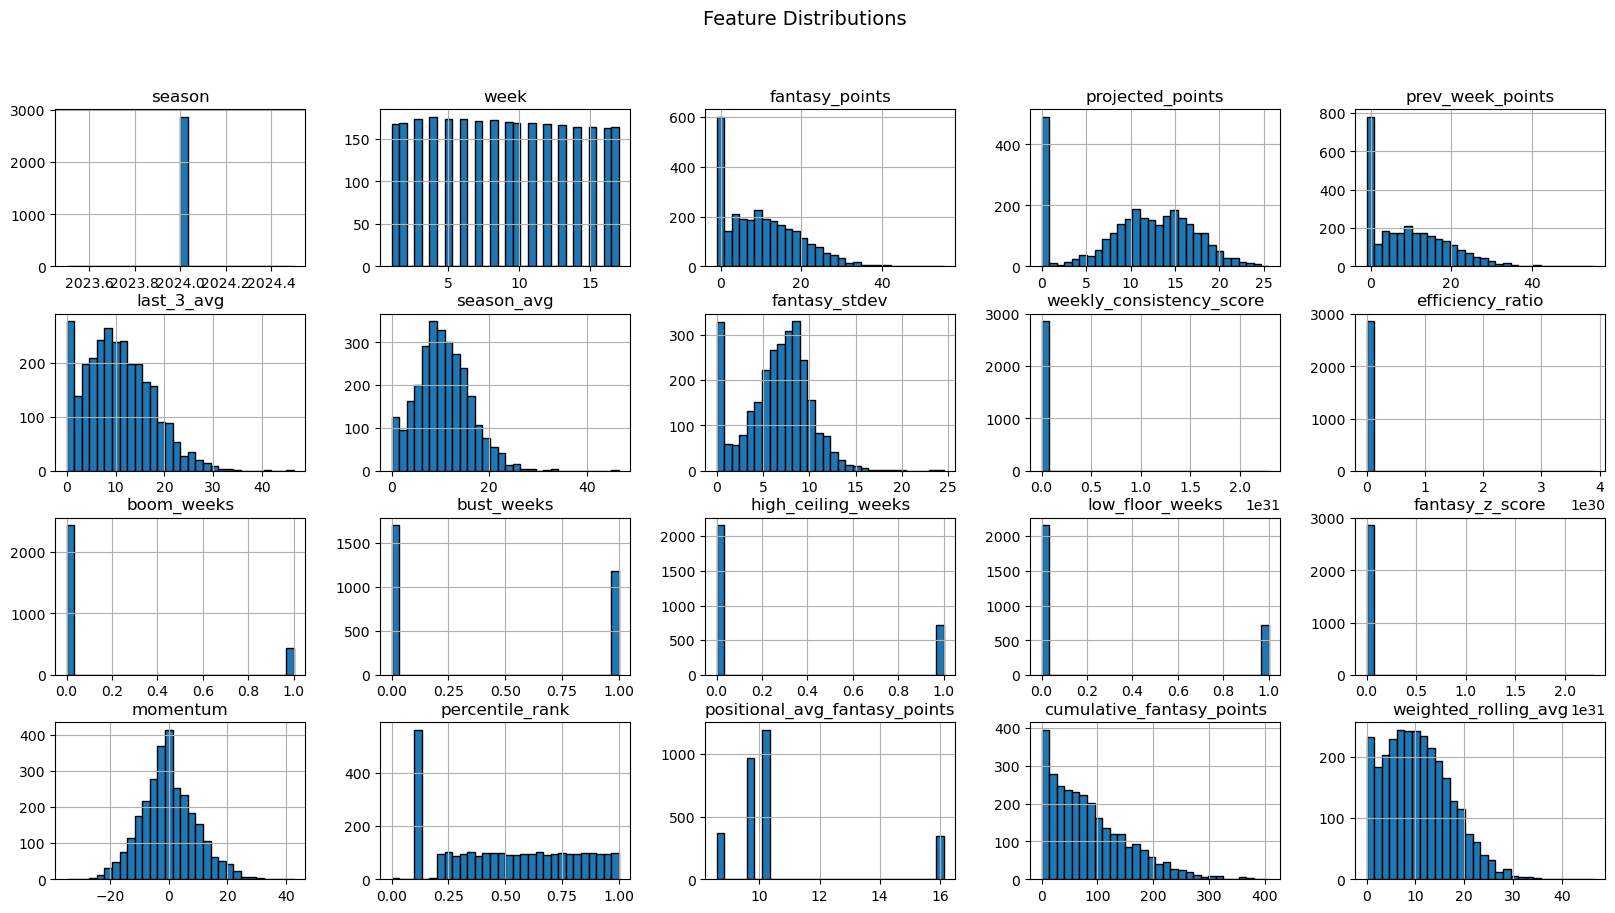

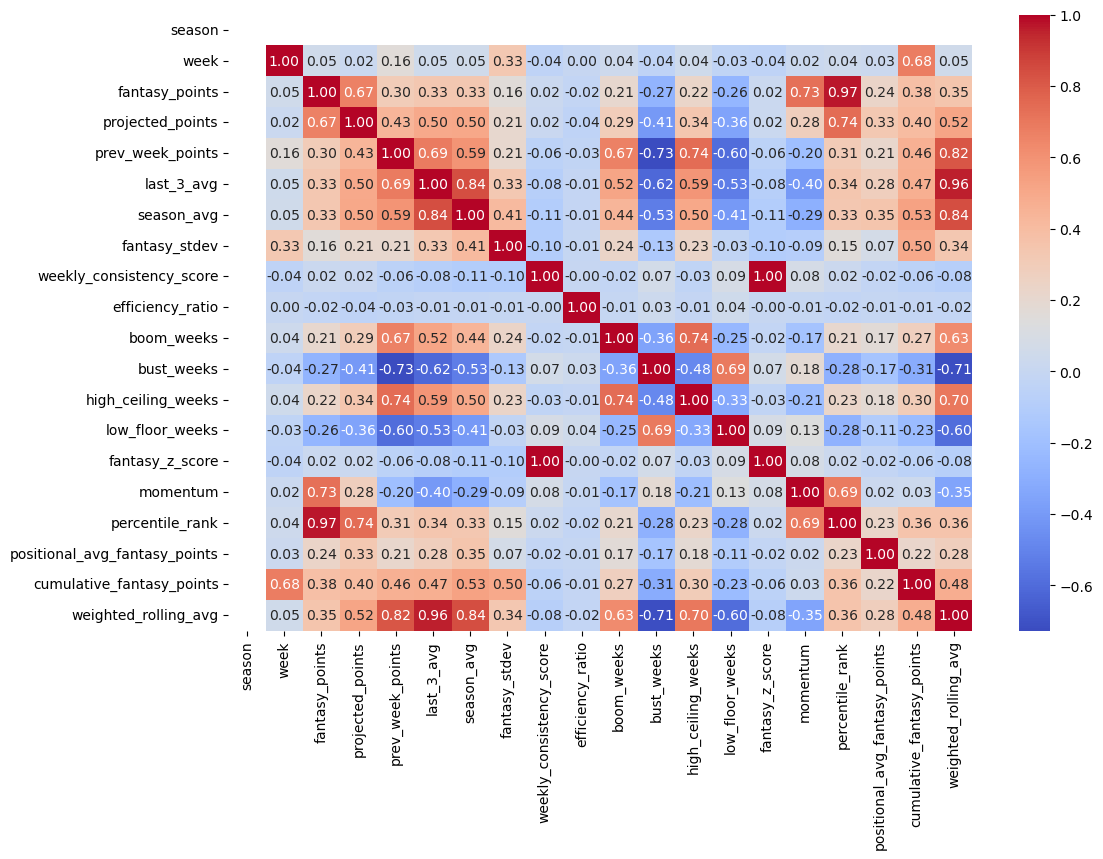

In [9]:
## call function perform quick EDA of weekly stats
quick_EDA(weekly_stats)

In [10]:
## call function to remove strongly correlated features
weekly_stats = remove_correlated_features(weekly_stats, threshold=0.90)

## preview data
weekly_stats.head()

,season,week,player_id,player_name,team,position,fantasy_points,projected_points,prev_week_points,last_3_avg,season_avg,fantasy_stdev,efficiency_ratio,boom_weeks,bust_weeks,high_ceiling_weeks,low_floor_weeks,fantasy_z_score,momentum,positional_avg_fantasy_points,cumulative_fantasy_points
0,2024,1,8439,Aaron Rodgers,NYJ,QB,8.58,16.17,0.00,0.000000,0.00,0.000000,0.530612,0.0,0.0,0.0,0.0,0.000000,0.000000,16.133567,8.58
1,2024,2,8439,Aaron Rodgers,NYJ,QB,15.14,16.65,8.58,8.580000,8.58,0.000000,0.909309,0.0,0.0,0.0,0.0,0.000000,6.560000,16.133567,23.72
2,2024,3,8439,Aaron Rodgers,NYJ,QB,21.04,15.52,15.14,11.860000,11.86,4.638620,1.355670,0.0,0.0,0.0,0.0,1.979037,9.180000,16.133567,44.76
3,2024,4,8439,Aaron Rodgers,NYJ,QB,11.60,15.45,21.04,14.920000,14.92,6.232913,0.750809,1.0,0.0,1.0,0.0,-0.532656,-3.320000,16.133567,56.36
4,2024,5,8439,Aaron Rodgers,NYJ,QB,11.76,14.14,11.60,15.926667,14.09,5.353043,0.831683,0.0,0.0,0.0,0.0,-0.435266,-4.166667,16.133567,68.12


In [11]:
## save processed data for Neural Network
weekly_stats.to_csv("./data/NN_weekly_stats.csv", index=False)

In [12]:
#############################################
## Feature Engineering - Player Level Stats
#############################################

## aggregate weekly data to compute key player metrics at the player level
player_stats = weekly_stats.groupby(["player_id", "player_name", "position"]).agg({
    "fantasy_points": ["sum", "mean", "std", "var"],                                  ## total fantasy points, PPG, standard deviation, variance
    "projected_points": ["sum", "mean"],                                              ## total projected points, projected PPG
    "week": "count",                                                                  ## number of weeks played this season
    "prev_week_points": "mean",                                                       ## average fantasy points in previous week
    "last_3_avg": "mean",                                                             ## rolling 3-game average
    "boom_weeks": "sum",                                                              ## boom weeks over 20 FP
    "bust_weeks": "sum",                                                              ## bust weeks under 7 FP
    "high_ceiling_weeks": "sum",                                                      ## high ceiling weeks with top 25% performance
    "low_floor_weeks": "sum",                                                         ## low floor weeks with bottom 75% performance
    "momentum": "sum"                                                                 ## overall performance momentum score this season
}).reset_index()

## rename columns for clarity
player_stats.columns = ["player_id", "player_name", "position", "total_fantasy_points", "ppg", 
                        "fantasy_stdev", "fantasy_var", "total_projected_points", "projected_ppg",
                        "weeks_played", "prev_week_points", "last_3_avg", "boom_weeks", "bust_weeks",
                        "high_ceiling_weeks", "low_floor_weeks", "momentum"]

## availability score to capture % of games played in a season
player_stats["availability_score"] = (player_stats["weeks_played"] / 17)

## create weekly consistency score where higher values indicate more reliable players
player_stats["weekly_consistency_score"] = (player_stats["ppg"] / (player_stats["fantasy_stdev"] + 1e-30))

## create efficiency ratio of how well a player performs relative to projections
player_stats["efficiency_ratio"] = (player_stats["total_fantasy_points"] / (player_stats["total_projected_points"] + 1e-30))

## fill NaN values and set correct data types
player_stats.fillna(0, inplace=True)

player_stats.head()

,player_id,player_name,position,total_fantasy_points,ppg,fantasy_stdev,fantasy_var,total_projected_points,projected_ppg,weeks_played,prev_week_points,last_3_avg,boom_weeks,bust_weeks,high_ceiling_weeks,low_floor_weeks,momentum,availability_score,weekly_consistency_score,efficiency_ratio
0,8439,Aaron Rodgers,QB,231.62,13.624706,7.537724,56.817276,251.58,14.798824,17,13.596471,13.072549,3.0,2.0,6.0,1.0,0.806667,1.000000,1.807536,0.920661
1,14880,Kirk Cousins,QB,176.32,10.371765,9.658592,93.288403,226.38,13.316471,17,10.371765,11.571176,2.0,7.0,4.0,4.0,-20.390000,1.000000,1.073838,0.778867
2,14881,Russell Wilson,QB,122.58,15.322500,6.305766,39.762679,123.36,15.420000,8,13.110000,13.764167,1.0,2.0,2.0,1.0,12.466667,0.470588,2.429919,0.993677
3,15795,DeAndre Hopkins,WR,147.00,8.647059,7.442288,55.387647,164.64,9.684706,17,8.488235,8.938235,1.0,7.0,3.0,4.0,-4.950000,1.000000,1.161882,0.892857
4,15807,Cordarrelle Patterson,RB,8.20,2.050000,4.100000,16.810000,8.51,2.127500,4,2.050000,5.341667,0.0,3.0,0.0,2.0,-13.166667,0.235294,0.500000,0.963572


DataFrame Shape: (242, 20)

Data Types:
 player_id                     int64
player_name                  object
position                     object
total_fantasy_points        float64
ppg                         float64
fantasy_stdev               float64
fantasy_var                 float64
total_projected_points      float64
projected_ppg               float64
weeks_played                  int64
prev_week_points            float64
last_3_avg                  float64
boom_weeks                  float64
bust_weeks                  float64
high_ceiling_weeks          float64
low_floor_weeks             float64
momentum                    float64
availability_score          float64
weekly_consistency_score    float64
efficiency_ratio            float64
dtype: object

Summary Statistics:
        total_fantasy_points         ppg  fantasy_stdev  fantasy_var  \
count            242.000000  242.000000     242.000000   242.000000   
mean             124.217025    9.204584       6.390269    51.

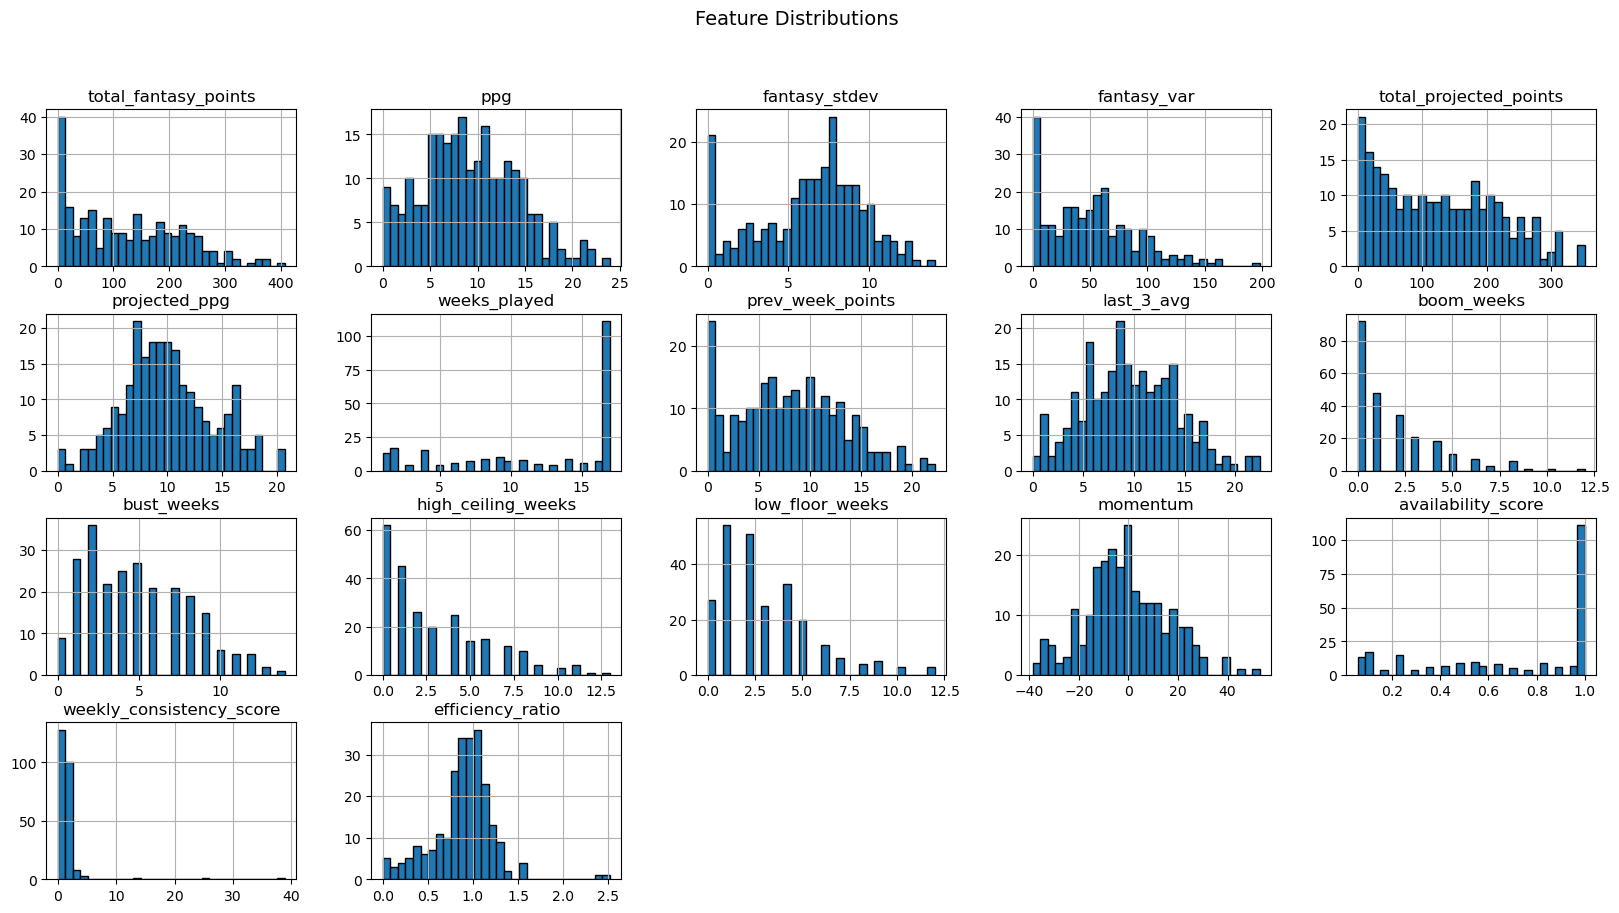

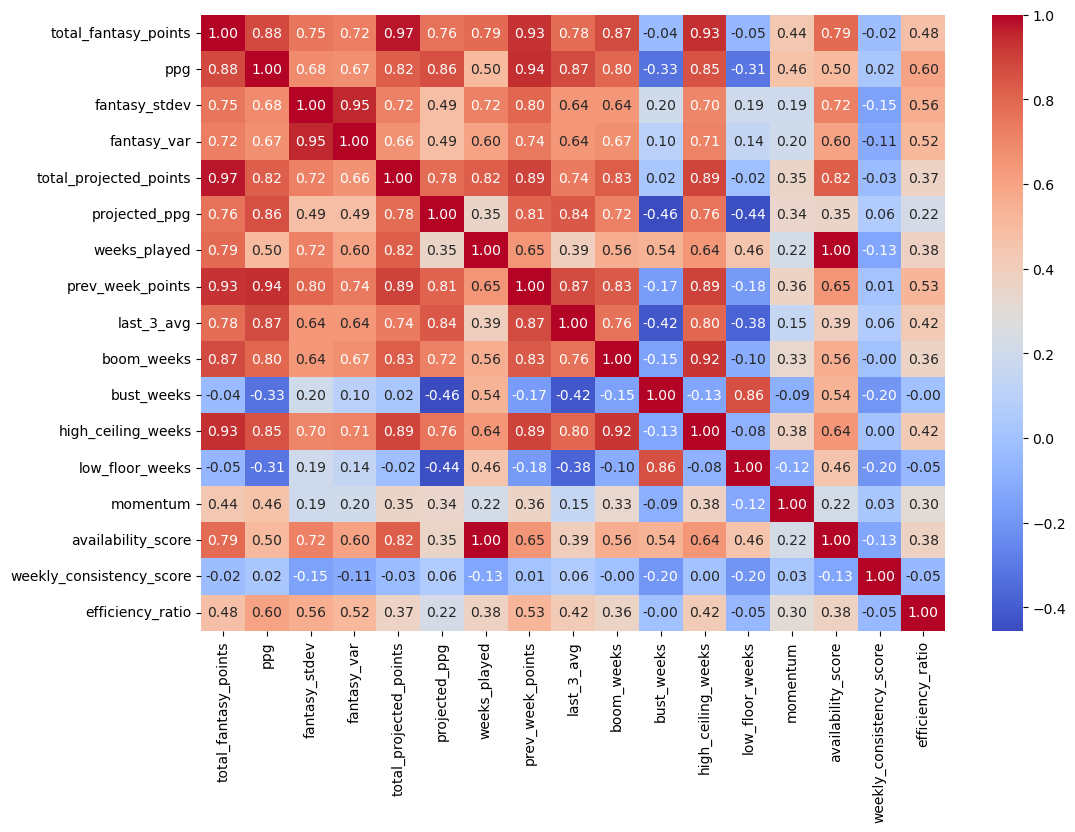

In [13]:
## call function perform quick EDA of player level stats
quick_EDA(player_stats)

In [14]:
## call function to remove strongly correlated features
player_stats = remove_correlated_features(player_stats, threshold=0.90)

## preview data
player_stats.head()

,player_id,player_name,position,ppg,fantasy_stdev,projected_ppg,last_3_avg,boom_weeks,bust_weeks,low_floor_weeks,momentum,availability_score,weekly_consistency_score,efficiency_ratio
0,8439,Aaron Rodgers,QB,13.624706,7.537724,14.798824,13.072549,3.0,2.0,1.0,0.806667,1.000000,1.807536,0.920661
1,14880,Kirk Cousins,QB,10.371765,9.658592,13.316471,11.571176,2.0,7.0,4.0,-20.390000,1.000000,1.073838,0.778867
2,14881,Russell Wilson,QB,15.322500,6.305766,15.420000,13.764167,1.0,2.0,1.0,12.466667,0.470588,2.429919,0.993677
3,15795,DeAndre Hopkins,WR,8.647059,7.442288,9.684706,8.938235,1.0,7.0,4.0,-4.950000,1.000000,1.161882,0.892857
4,15807,Cordarrelle Patterson,RB,2.050000,4.100000,2.127500,5.341667,0.0,3.0,2.0,-13.166667,0.235294,0.500000,0.963572


In [15]:
## save processed data for GMM
player_stats.to_csv("./data/GMM_player_stats.csv", index=False)